In [48]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [49]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def get_node_path(start_node):
    if start_node <= max(int_to_cluster.keys()):
        cluster = int_to_cluster[start_node]
    else:
        # take any child
        cluster = list(node_dict[start_node]['left'])[0]
        
    nodes = [start_node]
    for k, v in node_dict.items():
        if k < start_node:
            continue
        else:
            if cluster in (v['left'] | v['right']):
                nodes.append(k)
    node_path = sorted(nodes, reverse=True)
    return node_path

def straight_branch(ax, a, b, plot_kws, vertical=False):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    if vertical:
        branch_x = [a_x, a_x, bx]
        branch_y = [ay, by, by]
    else:
        branch_x = [a_x, bx, bx]
        branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram(
        linkage_df,
        labels_list,
        dendro_dict,
        ax=None,
        branch_type='straight',
        plot_node_id=False,
        plot_kws=None,
        node_hue=None,
        node_hue_norm=None,
        node_palette=None,
        palette='viridis',  # shared by both line and node hue
        node_size=None,
        node_size_norm=None,
        line_hue=None,
        line_hue_norm=None,
        sizes=None,
        size=30,
        linewidth=1,
        color=None,
        vertical=False,
        highlight_node_path=None):
    if plot_kws is None:
        plot_kws = {}

    dendro = dendro_dict
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)), )
    else:
        node_hue = {}

        def node_cmap(_):
            raise

    node_colors = {
        node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
        for node in node_pos.keys()
    }
    
    if node_palette is not None:
        node_colors = node_palette
        
    if highlight_node_path:
        nodes = get_node_path(highlight_node_path)
        node_colors = {
            node: 'red' if (node in nodes) else node_colors[node]
            for node in node_pos.keys()
        }
    

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm))  # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise

    node_sizes = {
        node: node_smap(node_size[node]) if (node in node_size) else nan_size
        for node in node_pos.keys()
    }

    if vertical:
        node_pos = {k: v[::-1] for k, v in node_pos.items()}

    for node_id, (node_x, node_y) in node_pos.items():
        ax.scatter(node_x,
                   node_y,
                   s=node_sizes[node_id],
                   c=node_colors[node_id],
                   zorder=10-node_y)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values), vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise

    line_colors = {
        node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
        for node in node_pos.keys()
    }
    
    if highlight_node_path:
        nodes = get_node_path(highlight_node_path)
        line_colors = {
            node: 'red' if (node in nodes) else nan_color
            for node in node_pos.keys()
        }
        
    
    ymax = 0
    xmax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        # plot node id text
        if plot_node_id:
            if node_id >= n_leaves:
                ax.text(node_x,
                        node_y,
                        node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else
                        plot_kws['fontsize'],
                        ha='center',
                        va='center',
                        c='k', zorder=100)
            else:
                ax.text(node_x,
                        -0.01,
                        node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else
                        plot_kws['fontsize'],
                        ha='center',
                        va='center',
                        c='k', zorder=100)

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]
    
            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth),
                                 vertical=vertical)
    
            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth),
                                 vertical=vertical)
    if vertical:
        xmax = max(xmax, node_x)
        ax.set_xlim(xmax * 1.05, 0 - xmax * 0.05)
        
    else:
        ymax = max(ymax, node_y)
        ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    return node_pos, dendro

In [50]:
dendro = joblib.load(f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib')
linkage = pd.read_csv(f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.csv', 
                      header=0, index_col=0).reset_index(drop=True)
linkage_order = pd.read_csv(f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.orders.txt', 
                      header=None, index_col=0).index
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib'
)
subtype_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

In [4]:
name_map = {k.replace(' ', '.').replace('-', '.'):k for k in subtype_palette.keys()}

In [5]:
int_to_cluster = {i: cluster for i, cluster in zip(dendro['leaves'], dendro['ivl'])}

In [6]:
node_palette = {}
for leaf, cluster in zip(dendro['leaves'], dendro['ivl']):
    node_palette[leaf] = subtype_palette[name_map[cluster]]
    
upper_nodes = linkage.shape[0]
for i in range(upper_nodes):
    upper_node_id = upper_nodes + i + 1
    node_palette[upper_node_id] = '#D3D3D3'

[[], []]

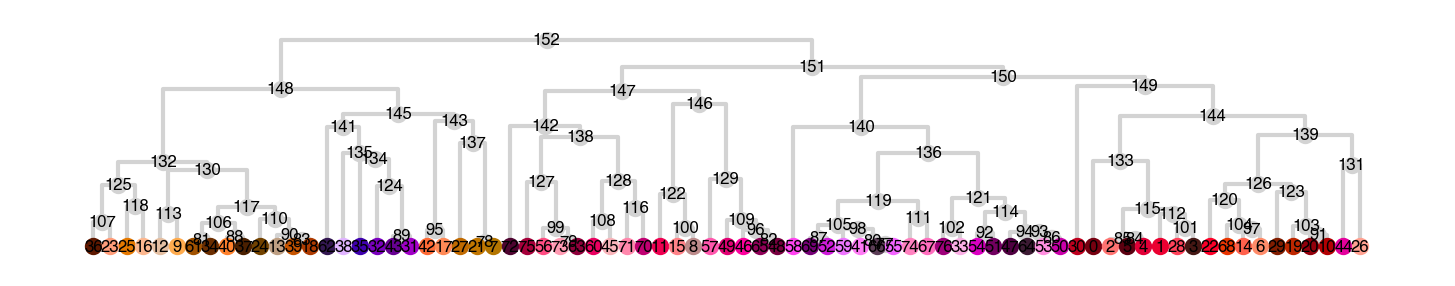

In [7]:
fig, ax = plt.subplots(figsize=(6, 1), dpi=300)

plot_dendrogram(linkage_df=linkage,
                labels_list=linkage_order,
                dendro_dict=dendro,
                ax=ax,
                size=10,
                node_palette=node_palette,
                plot_node_id=True,
                vertical=False)
sns.despine(ax=ax, left=True, bottom=True)
ax.set(xticks=[], yticks=[])

In [8]:
import numpy as np
def barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
            estimator=np.mean, ci=95, n_boot=1000, units=None, seed=None,
            orient=None, color=None, palette=None, saturation=.75,
            errcolor=".26", errwidth=None, capsize=None, dodge=True,
            ax=None, **kwargs):

    plotter = _BarPlotter(x, y, hue, data, order, hue_order,
                          estimator, ci, n_boot, units,
                          orient, color, palette, saturation,
                          errcolor, errwidth, capsize, dodge)
    plotter.width=1
    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    return ax

from seaborn.categorical import _BarPlotter

In [9]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
region_order = ['MOB', 'AON', 'PIR', 'ORB', 'PFC', 'AI', 'ACA', 'MOs', 'MOp', 'SSp', 'SSs', 
       'CA1-3', 'DG', 'CP', 'ACB', 'PAL', 'LSX']

cell_counts = cell_tidy_data.groupby('SubType')['SubRegion'].value_counts().unstack().fillna(0)
cell_rates = cell_counts / cell_counts.sum(axis=1)[:, None]

bar_data = []
for cluster, row in cell_rates[region_order].iterrows():
    record = row[row > 0].cumsum().reset_index()
    record['SubType'] = cluster
    record.columns = ['Region', 'value', 'SubType']
    bar_data.append(record)
bar_data = pd.concat(bar_data)

sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
total_result = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhDMR/NodeMotifResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [69]:
gene_result = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhGeneToTree/NodeGeneResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')

for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))
motif_gene_anno[motif_gene_anno['gene_names'] == 'Rora']

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0071.1,RORA,RORA,ENSMUSG00000032238.17,Rora,MotifGroup81,Nuclear receptors with C4 zinc fingers,Thyroid hormone receptor-related factors,ROR(NR1F)
MA0072.1,RORA(var.2),RORA,ENSMUSG00000032238.17,Rora,MotifGroup125,Nuclear receptors with C4 zinc fingers,Thyroid hormone receptor-related factors,ROR(NR1F)


In [41]:
node_hue = total_result['MA0072.1']
node_hue = node_hue.to_dict()

In [51]:
linkage_node_index = linkage.copy()
linkage_node_index.index = linkage.index + 77

parent_child_dict = {}
for parent, (left, right, *_) in linkage_node_index.iterrows():
    parent_child_dict[parent] = {'l': int(left), 'r': int(right)}


In [79]:
child_hue = {}
for k, v in node_hue.items():
    sign = v > 0
    if abs(v) < 0.8:
        continue
    if sign:
        child = parent_child_dict[k]['l']
    else:
        child = parent_child_dict[k]['r']
    child_hue[child] = abs(v)

In [81]:
import xarray as xr


In [84]:
mcds = xr.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/Select*mcds'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [85]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

In [87]:
def add_gene_data(gene):
    if gene not in cell_tidy_data.columns:
        gene_id = gene_name_to_id[gene]
        gene_data = mcds.sel(gene=gene_id, cell=cell_tidy_data.index, mc_type='CHN')['gene_da'].to_pandas()
        cell_tidy_data[gene] = gene_data

In [88]:
add_gene_data('Rora')

[(0.5, 3), (-3.8058713443102192, 79.89836270774624)]

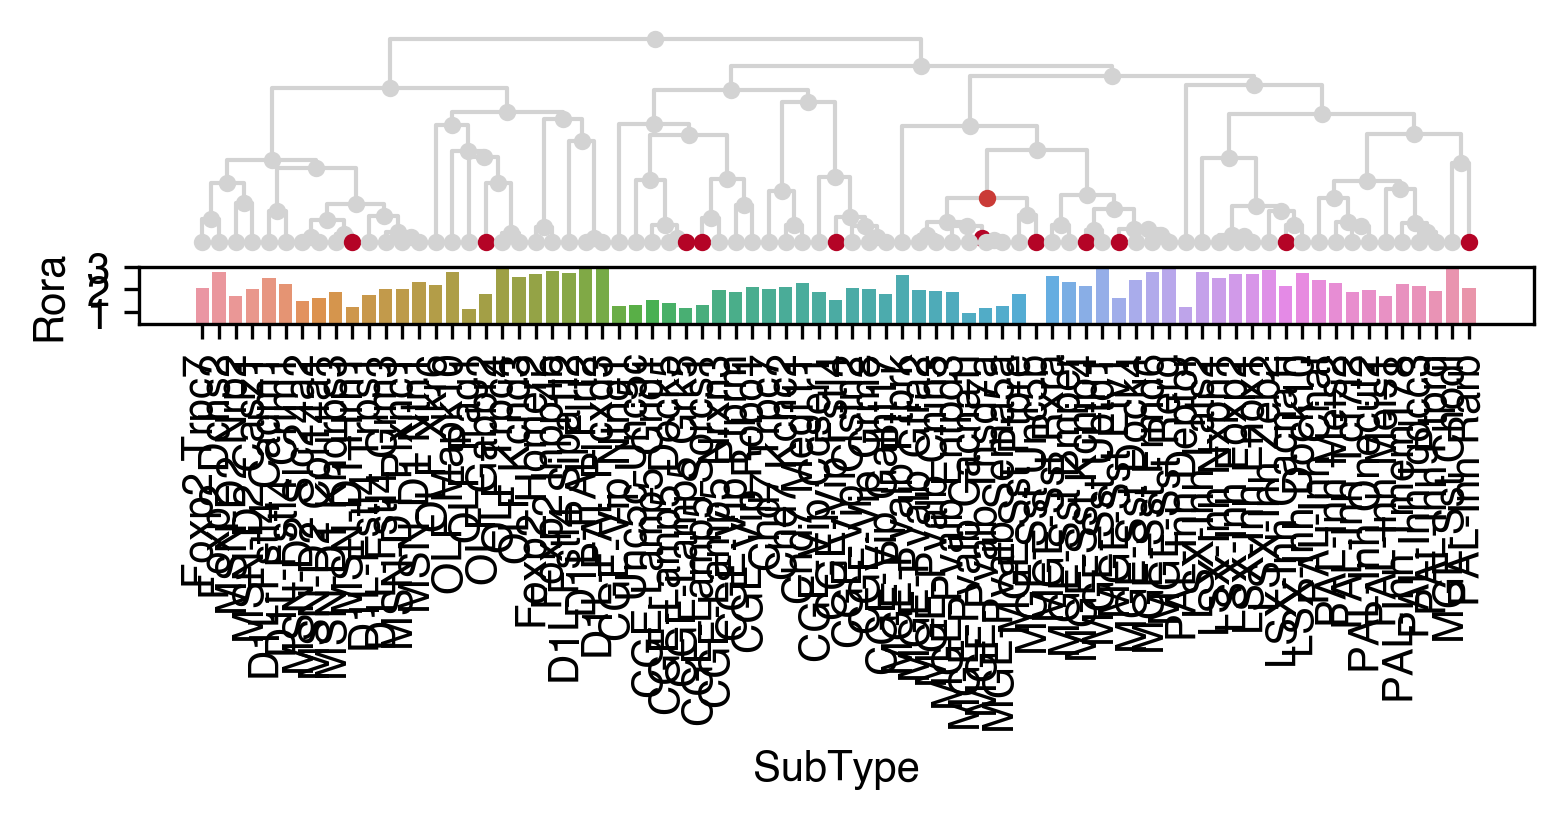

In [99]:
fig = plt.figure(figsize=(6, 1.3), dpi=300)

gs = fig.add_gridspec(13, 1, hspace=1.5)

ax_tree = fig.add_subplot(gs[:10, 0])
ax_bar = fig.add_subplot(gs[10:, 0])

node = 95
ax = ax_tree
plot_dendrogram(linkage_df=linkage,
                labels_list=linkage_order,
                dendro_dict=dendro,
                ax=ax,
                size=10,
                node_hue=child_hue,
                node_hue_norm=(-1, 1),
                palette='coolwarm',
                plot_node_id=False,
                vertical=False,
                highlight_node_path=None)
sns.despine(ax=ax, left=True, bottom=True)
ax.set(xticks=[], 
       xticklabels=[],
       yticks=[])
ax.xaxis.set_tick_params(rotation=90, labelsize=4)

ax=ax_bar
sns.barplot(ax=ax, x='SubType', y='Rora', data=cell_tidy_data,
               order=[name_map[i] for i in dendro['ivl']], linewidth=0, ci=None)
ax.xaxis.set_tick_params(rotation=90)
ax.set(ylim=(0.5, 3), xlim=ax_tree.get_xlim())

# sns.despine(left=True, bottom=True)
# ax.set(yticks=[], xticklabels=[], xlabel='', ylabel='', xlim=ax_tree.get_xlim())
# ax.xaxis.tick_top()
# ax.set_xticks(range(len(dendro['ivl'])))

# ax.legend_.set_visible(False)

